# Packages installation

In [ ]:
#install packages needed if necessary
#!pip install matplotlib
#!pip install particles

# Importations

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from numpy import log
import time

import seaborn as sb
import scipy.stats as stats
from scipy.special import logsumexp

# Modules from particles
import particles 
from particles import distributions as dists
from particles import collectors 

# 0 - A word about what we are trying to achieve

Generally, for the type of problems we are speaking about, we deal with:
- An hidden variable $X_t$ that follows a markov process. This variable can be multivariate. It is characterized by a **transition kernel**.
- An observed variable $Y_t$ whose distribution depends on $X_t$. It is characterized by an **emission law**. 

The basic task is, given that we *know* the transition kernel, the emission law, and all their parameters, to recover the $X_t$ based on a sequence of $Y_t$ (*filtering* / *complete smoothing*).

A more challening tasks is to perform **bayesian inference**, that is, to estimate the posterior of the parameters given the data (and prior on the parameters). This task relies on particle MCMC algorithms. 

In our setting: 

- $X$ is composed of 
    - $u_t$, the expression level. It is the variable that, in real life, researchers are trying to recover. 
    - $s_t$, the local scaling term. A variable that follows a markov process independently from everything else and will be useful at some point. 
    - We might even add $a_t$ and $x_t$
- $Y$ is simply $y_t$, the read counts. It is basically **a noisy observation of $u_t$**. Its distribution is described by the **emission law** that involves $u_t$ and $s_t$. 

##  0.1 - What we have to do 

Given the level of complexity of the model, our assignment has changed. We can focus on:

1. **Creating the model**
    - Having a working subclass of Feynman Kac 
    - Being able to generate data (should not be too hard)

2. **Generating some data**

3. **Using the bootstrap filter**

4. **Using the PMMH algorithm to perform some bayesian inference**

## 0.2  -How we are going to do it 

Since our model is pretty complicated, the previous approach subclassing (ssm.StateSpaceModel) will not work. 
Instead, we are going to define ourselves a Feynman-Kac model as explained here: 
https://particles-sequential-monte-carlo-in-python.readthedocs.io/en/latest/notebooks/Defining_Feynman-Kac_models_manually.html

- In the method $M$, we define a way to sample from our X. We do so using a function, that can be used as well for data generation. 
- In the method $logG$, we are going to compute the loglikelihood 

Importantly, note that $x_p$ and $x$ are **tables containing N particles**, we need to loop through them.

To speed things up, we might need to rely on the **numba** python package. 

In [2]:
# The simple example of a feynman-kac model from the package

class GaussianProb(particles.FeynmanKac):
    def __init__(self, a=0., b=1., T=10):
        self.a, self.b, self.T = a, b, T

    def M0(self, N):
        return stats.norm.rvs(size=N)

    def M(self, t, xp):
        return stats.norm.rvs(loc=xp, size=xp.shape)

    def logG(self, t, xp, x):
        return np.where((x < self.b) & (x > self.a), 0., -np.inf)

## 0.3 - Choice regarding the drifts
The explanations in the supplementary materials are unclear. What we are chosing to do is:

**Upward drift**

$u_{t+1} = u_t + Z, \quad Z \sim \mathcal{E}(\frac{\lambda_u}{u_t})$

**Downward drift**

$u_{t+1} = u_t - Z, \quad Z \sim \mathcal{E}(\frac{\lambda_d}{u_t})$

## 0.4 - Parametrization of distributions

1. Exponential
- In both cases above, the exponential is parametrized by its **RATE**, whereas the numpy funciton works in terms of **SCALE**
2. Gamma
- The gamma class from particles.dists uses a RATE parameter b (a SCALE parameter 1/b)
- In the supplementary materials, they are using a SCALE theta !
3. Negative binomial
- In the article, they state that its mean is $\frac{rp}{1-p}$
- But in scipy, they say the mean is $\frac{r(1-p')}{p'}$
- So we will use scipy, and define $p' = 1-p$

## 0.5 - Regarding the emission law

**We have two definitions of it**
- The first will be useful to generate the data;
- The second will be useful to compute the likelihood. It involved an infinite sum, that we truncate at 10 or 30. 

## 0.6 - Regarding the multiple parameters of the model

It's easy to get lost in the multiplicity of the parameters. Here is a summary of the **16 parameters**

### For the kernle of u_t
- For when $u_t = 0 \quad$ eta, zeta ($\eta,\zeta$)
- For when $u_t >0$
  - Outside of the drifts: alpha, beta, beta_0 ($\alpha, \beta, \beta_0$) 
  - In the drift: gamma_u, gamma_d, lambda_u, lambda_d ($\gamma_u, \gamma_d, \lambda_u, \lambda_d$)

### For the kernel of s_t
- alpha_s, kappa_s ($\alpha_s, \kappa_s$)

### For the emission law (y_t)

- Probabilities: epsilon_b, epsilon_0 ($\epsilon_b, \epsilon_0$)
- Others: kappa, theta, b ($\kappa, \theta, b$)

### Initial law

- For the initialisation of the kernel in the FK-model and in the data generation, we need an initial law
- We did not found one in the paper
- For $s_t$ starting at 0 does not seem to be an issue
- BUT for $u_t$, it is, since the probability of staying in 0 if it is in 0 is very high. So instead, we initialize it as the distribution it follows with a low probability if the precedent value was 0.

### Values that make sens

- See table S2 in the supplementary materials (p17).

- **Except for b**, which we might have to chose. b is a particular case, because in the supplmentary material it is said that " in practice b is set to max(*y*)". But in our case, we need it to generate our data, so BEFORE we have any y. From figure 3 of the article, it seems that setting b = 10 would be a reasonnable choice.

- There is no $\epsilon_b$ in the table, but there is an $\epsilon$ so we guess they are the same. 


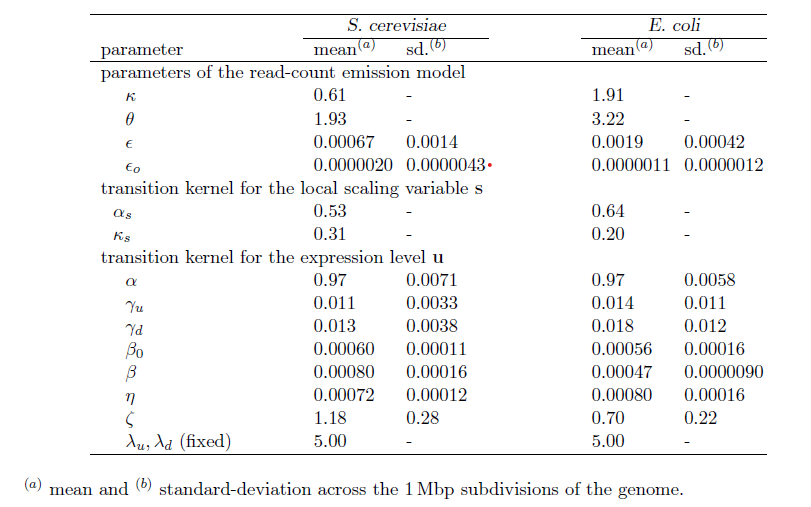

<h1 align = "center"> ------------------- </h1>

<h1 align = "center"> TO DO </h1>

### - Search for an issue in data generation ? 

### - Test the boostrap filter and see what is the output (of alg)

This 2 points seems to be repear 


### - See if we can speed up the process (numba ?)

### - Work with longer data

### - How to use PMMH because we have a FK but we did not define a SSM ? 

### - Initialize the report

<h1 align = "center"> ------------------- </h1>

In [7]:
# Seed
rng = np.random.default_rng(seed = 42) 

# 1 - Defining data genration and the Feynman-Kac model 

### Kernel step

In [21]:
def stepX(xp, 
          eta, alpha, zeta, beta, beta_0, 
          gamma_u, gamma_d, lambda_u, lambda_d,
          alpha_s, kappa_s):
    """
    Performs a step of the kernel
    """
    # xp[0] is u_t
    # xp[1] is s_t
    # The same holds for x
    
    x = np.zeros(shape = (2))
    
    # Computations for u_t
    uniu = dists.Uniform(a = 0., b = 1.).rvs(size = 1) # Uniform to "choose a move"
    
    if xp[0] == 0 :
        if uniu <= 1 - eta:
            # Dirac on xp = 0 
            x[0] = 0
        else:
            # Exponential law with rate zeta 
            x[0] = rng.exponential(scale = 1 / zeta, size = 1)
            
    elif xp[0] !=0:
        if uniu <= alpha:
            # Dirac on xp
            x[0] = xp[0]

        elif uniu <= alpha + beta:
            # Exponential law with rate zeta 
            x[0] = rng.exponential(scale = 1 / zeta, size = 1)

        elif uniu <= alpha + beta + beta_0:
            # Dirac on 0
            x[0] = 0

        elif uniu <= alpha + beta + beta_0 + gamma_u:
            # Drift upward (rate lambda_u/xp[0])
            x[0] = xp[0] + rng.exponential(scale = xp[0]/lambda_u, size = 1)

        else:
            # Drift downward (rate lambda_d/xp[0])
            x[0] = xp[0] - rng.exponential(scale = xp[0]/lambda_d, size = 1)
        
        
    # Computations for s_t
    unis = dists.Uniform(a = 0., b = 1.).rvs(size = 1) # Uniform to "choose" a move 
               
    if unis <= alpha_s:
        x[1] = xp[1]
    else:
        #x[1] = dists.Gamma(a = kappa_s, b = 1/kappa_s).rvs(size = 1)
        x[1] = dists.Gamma(a = kappa_s, b = kappa_s).rvs(size = 1)
    
    if x[0] <  0:
        x[0] = 0.
        
        
    return x 

### Sampling y based on the hidden variable

In [22]:
def sampleY(x, kappa, theta, epsilon_b, epsilon_0, b):
    """
    Samples an observation y_t based on the vector x_t and some parameters
    Uses the 1st expression of the emission model 
    """
    
    # Sample the number of molecules initially sampled (x_t)
    x_t = dists.Poisson(rate = x[0]*x[1]/(kappa*theta)).rvs(size = 1)
                           
    # Sample the amplificaiton coefficient (a_t)
    #a_t = dists.Gamma(kappa, theta).rvs(size = 1)
    a_t = dists.Gamma(kappa, 1/theta).rvs(size = 1)
                       
    # Sample the read counts (y_t)
    uniy = dists.Uniform(a = 0., b = 1.).rvs(size = 1) # Uniform to "choose a move"
    
    # With proba "1 - epsilon_b - epsilon_0"
    if uniy < 1 - epsilon_b - epsilon_0:
        y = dists.Poisson(rate = x_t*a_t).rvs(size = 1)
    
    # With proba "epsilon_b"
    elif uniy < 1 - epsilon_0:
        # Generate following a Poisson distribution truncated in 0     
        # We generate from it until we get a non-zero value
        proposition = 0 
        while proposition == 0:
            proposition = dists.Poisson(rate = 1*a_t).rvs(size = 1)
        y = proposition
                       
    # With proba "epsilon_0"
    else:
        y = dists.DiscreteUniform(0, b+1) 
    return y 

### Generating synthetic data
That will then analyze

In [23]:
def generate_data(length, 
                  eta, alpha, zeta, beta, beta_0, 
                  gamma_u, gamma_d, lambda_u, lambda_d,
                  alpha_s, kappa_s,
                  kappa, theta, epsilon_0, epsilon_b, b):
    """
    Function that allows to generate data (that we can then analyze)
    length  is the length of the data to be generated
    """
    
    # Initialisation 
    X = np.zeros(shape = (length, 2))
    Y = np.zeros(shape = length)
    
    # Time = 0
    X[0, 1] = 0. # Initial law chosen to be 0 for s_t
    X[0, 0] = 0.
    #X[0,0] = rng.exponential(scale = 1 / zeta, size = 1) #Non-zero initial law for u_t
    #X[0,0] = 0.15
    
    Y[0] = sampleY(X[0,:], kappa = kappa, theta = theta, epsilon_b = epsilon_b, epsilon_0 = epsilon_0, b = b)
    
    # Time = 1, ...., length; technically in our case it is space, not time 
    for time in range(1, length):
        
        # Update X (one kernel step)
        X[time, :] = stepX(X[time - 1, :], 
                        eta = eta, alpha = alpha, zeta = zeta, beta = beta, beta_0 = beta_0, 
                        gamma_u = gamma_u, gamma_d=gamma_d, lambda_u = lambda_u, lambda_d = lambda_d,
                        alpha_s = alpha_s, kappa_s = kappa_s)
    
        # Sample from Y|X (from the law og Y given X)
        Y[time] = sampleY(X[time,:], kappa = kappa, theta = theta, epsilon_b = epsilon_b, epsilon_0 = epsilon_0, b = b)
    
    return X, Y

### Defining (manually) the Feynman-Kac model
- A slight uncertainty about the use of parameter "loc" in the scipy.ADIST.logpmf function calls.
- In the computation of the loglikelihood, we rely on the **logsumexp** trick. It is useful to compute things of the form $log(\Sigma a_i)$ by using the fact that $$log(\Sigma a_i) = log \Sigma exp(log(a_i)) = log \Sigma exp(v_i)$$ where $v_i = log(a_i)$. This second form is more stable numerically. We rely twice on this trick, one for the infinite sum that we truncate and once for computing the log of the sum of the 3 terms (because our likelihood is decomposed into 3 terms).
See scipy documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.logsumexp.html

In [24]:
class RnaProb(particles.FeynmanKac):
    
    def __init__(self, 
                 data_observed,
                 T,
                 sum_truncation = 10,
                 eta = 0.05, alpha=0.97, zeta=1.18, beta=8e-4, beta_0=6e-4, # eta = 7.2e-4
                 gamma_u=0.011, gamma_d=0.013, lambda_u=5.0, lambda_d=5.0,
                 alpha_s=0.53, kappa_s=0.31,
                 kappa=0.61, theta=1.93, epsilon_0=2e-6, epsilon_b=6.7e-4, b = 10):
        
        # The observed data ie the y_t
        self.data_observed = data_observed
        # The length of the data
        self.T = T
        # The truncation for the infinite sum in the likelihood
        self.sum_truncation = sum_truncation
        
        self.eta = eta 
        self.alpha = alpha
        self.zeta = zeta 
        self.beta = beta 
        self.beta_0 = beta_0 
        
        self.gamma_u = gamma_u 
        self.gamma_d = gamma_d 
        self.lambda_u = lambda_d 
        self.lambda_d = lambda_d
        
        self.alpha_s = alpha_s 
        self.kappa_s = kappa_s
        
        self.kappa = kappa 
        self.theta = theta 
        self.epsilon_0 = epsilon_0
        self.epsilon_b = epsilon_b 
        self.b = b 

        
    def M0(self, N): # N particles 
        x0 = np.zeros(shape = (N,2)) 
        #x0[:,0] = rng.exponential(scale = 1 / self.zeta, size = N) #Non-zero initial law for u_t
        #x0[:,0] = 0.15
        return x0
    
    def M(self, t, xp):
                 
        # Initialize empty vector
        # It has two columns, one for u_t and one for s_t
        x = np.zeros(shape = xp.shape) 
        N = xp.shape[0]
        
        # Loop over the particles
        for i in range(N):
            # Call the function that does one move using the kernel of x
            x[i,:] = stepX(xp[i,:], 
                          eta = self.eta, alpha = self.alpha, zeta = self.zeta, beta = self.beta, beta_0 = self.beta_0, 
                          gamma_u = self.gamma_u, gamma_d = self.gamma_d, lambda_u = self.lambda_u, lambda_d = self.lambda_d,
                          alpha_s = self.alpha_s, kappa_s = self.kappa_s) 
            
        return x
    
                 
    def logG(self, t, xp, x):
        
        # We wish to compute the log of the conditional likelihood, which involves 3 terms
        # We compute the log of each term, then we use the logsumexp funciton
        # In here, data_observed[t] corresponds to y_t
        
        # AND we wish to do so for each of the N particles, hence the looop 
        # MAYBE vectorization would be possible ? 
        
        N = x.shape[0] # The number of particles is the first dimension of the array x
        NlogGs = np.zeros(N) #Initizaling the empty vector of log probabilities
        
        # Computaion of the terms that do not depend on the particle (ie on the X)
        ## 2nd term - NB truncated in 0 (does not depend on the particle)
        ## The likelihood can be obtained by dividing the classical likelihood by 1 - probability of getting 0 
        # Beware the formulations of the NB. Given in the article they state its mean is rp/(1-p)
        # and in scipy it says r(1 -p')/p', we will use p' = 1-p

        term_2 = log(self.epsilon_b) + \
            stats.nbinom.logpmf(k = self.data_observed[t], n = self.kappa, p = 1 - (self.theta /(1+self.theta))) + \
            stats.nbinom.logpmf(k = 0, n = self.kappa, p = 1 - (self.theta /(1+self.theta)))

        ## 3rd term - Discrete Uniform 
        # Discarding this if statement would induce a small approximation but could greatly accelerate the computation
        term_3 = 0 
        if self.data_observed[t] <= self.b: # To account for the indicator in the density of the uniform
            term_3 = log(self.epsilon_0) + log(1/(self.b))

        
        for i in range(N):
            
            # 1st term - Truncated infinite sum
            # Computation of the log of the terms in the sum
            summation_terms = np.zeros(self.sum_truncation)
            
            # The loop involves a product that stays the same in the loop for one particle: u_t*s_t
            # we don't want to compute it  at each step
            product = x[i,0]*x[i,1]
            
            for x_t in range(0, self.sum_truncation):
                summation_terms[x_t] =  stats.poisson.logpmf(k = x_t, mu=product/(self.kappa * self.theta)) + \
                    stats.nbinom.logpmf(k = self.data_observed[t], n = self.kappa, p = 1 - (self.theta*x_t /(1+self.theta*x_t)))

            # Computation of the log of the sum (+ the log of the coefficient in front)
            term_1 = log(1 - self.epsilon_b - self.epsilon_0) + logsumexp(summation_terms)
            
            # Agregation of the different terms 
            NlogGs[i] = logsumexp(np.array([term_1, term_2, term_3]))
        
        return NlogGs
        

# 2 - Generating data

In [25]:
# Actual generation of data 
T = 500
# We use the same parameters that inside the Feynman-Kac models 

data_X, data_Y  = generate_data(length = T, 
              eta =0.05, alpha=0.97, zeta=1.18, beta=8e-4, beta_0=6e-4, #eta = 7.2e-4
              gamma_u=0.011, gamma_d=0.013, lambda_u=5.0, lambda_d=5.0,
              alpha_s=0.53, kappa_s=0.31,
              kappa=0.61, theta=1.93, epsilon_0=2e-6, epsilon_b=6.7e-4, b = 10)

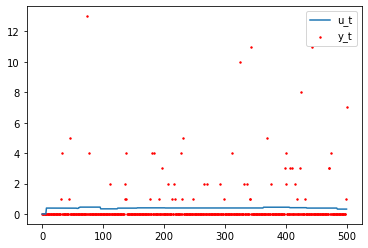

In [26]:
plt.scatter([i for i in range(T)], data_Y, s = 2, color = "red", label = "y_t")
plt.plot(data_X[:,0], label = "u_t")
plt.legend()
plt.show()

# It seems there is a differnce of scale betwwen u_t and s_t which is weird

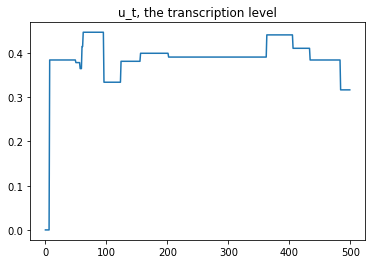

In [27]:
plt.plot(data_X[:,0])
plt.title("u_t, the transcription level")
plt.show()

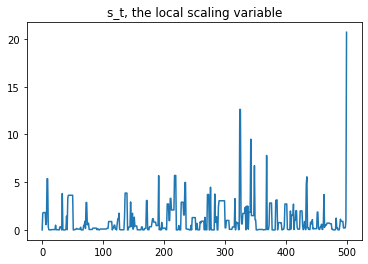

In [28]:
plt.plot(data_X[:,1])
plt.title("s_t, the local scaling variable")
plt.show()

# 3 - Bootsrap filter

In [29]:
# Preparation
N = 100
fk_rna = RnaProb(data_observed = data_Y, T = T)
alg = particles.SMC(fk = fk_rna, N = N, collect = [collectors.Moments()])

# Actual runing of the algorithm
start = time.time()
alg.run()
end = time.time()

print("Computation time for data of length {} and {} particules: {} secondes".format(T, N, end - start))


Computation time for data of length 500 and 100 particules: 39.8598051071167 secondes


**It works but it is a bit slow !**

In [34]:
# If we collect the moments during the computation, we get such dictionnary for each time:
print(alg.summaries.moments[0])
# There are two means and two variance for each iteration, the first for u_t and the second for s_t

{'mean': array([0., 0.]), 'var': array([0., 0.])}


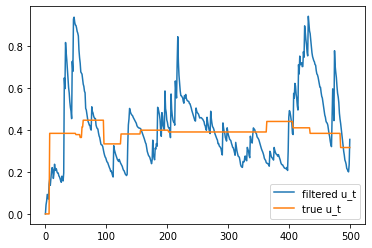

In [35]:
plt.plot([m["mean"][0] for m in alg.summaries.moments], label = "filtered u_t")
plt.plot(data_X[:,0], label = "true u_t")
plt.legend()

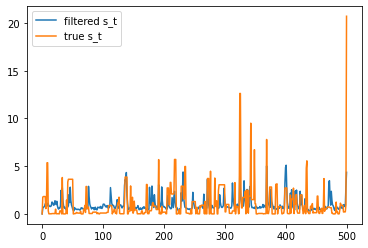

In [36]:
plt.plot([m["mean"][1] for m in alg.summaries.moments], label = "filtered s_t")
plt.plot(data_X[:,1], label = "true s_t")
plt.legend()

**To properly finish this part, we should**
- Play with the parameter "sum_truncation"
- Use the filter several times (about 10) in order to have an estimate of the variance
- Use many particles (but there's a tradeoff between the number of particles and the lenght of the data we can use)

# 4 - PMMH
Performing bayesian inference on some parameters

**We won't perform the inference on all the parameters !**
The paper states the following:
- $\kappa$, $\theta$, $\kappa_s$ and $\alpha_s$, parameters of the emission model, can be estimated without PMMH (by doing some stuff on portions of the real data). Therefore, it seems logical to consider them fix in our case.
- It is difficult to estimate at the same time the frequence ($\gamma_u$ and $\gamma_d$) and the amplitude ($\lambda_u$ and $\lambda_d$). Thus, they chose to fix the $\lambda$s and to estimate only the $\gamma$s. It seems smart to do the same in our case. 
- Finally, because $b$ is chosen according to the data, I think we should consider him fixed as well.

**So we've got 7 fixed parameters**

Here are the priors used by the authors for the remaining 9 (+1) parameters:
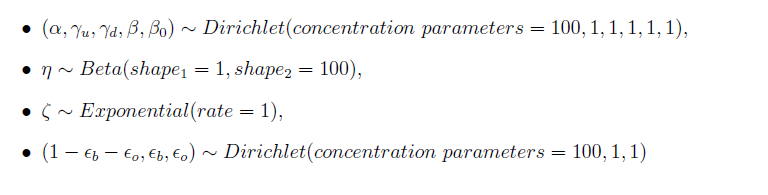

##TO DO : corriger les dirichlet distribution 

In [61]:
from particles import mcmc


In [50]:
"""
'alpha': 0.97
'gamma_u': 0.011
'gamma_d': 0.013
'beta': 8e-4
'beta_0':6e-4
'epsilon_0':2e-6
"""

prior_dict = {'eta': dists.Beta(1.,100.),
              'zeta': dists.Gamma(1,1)}
my_prior = dists.StructDist(prior_dict)

In [58]:
another_theta = my_prior.rvs(size=50000)

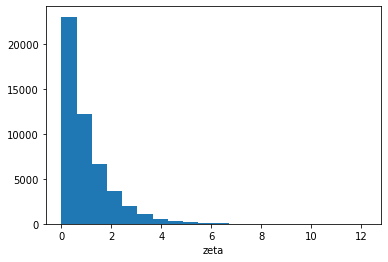

In [60]:
plt.hist(another_theta['zeta'], 20)
plt.xlabel('zeta');

In [68]:
# -*- coding: utf-8 -*-

"""
MCMC (Markov chain Monte Carlo) and related algorithms.

Overview
========

This module contains various classes that implement MCMC samplers:

    * `MCMC`: the base class for all MCMC samplers;

    * `GenericRWHM`: base class for random-walk Hastings-Metropolis;

    * `GenericGibbs`: base class for Gibbs samplers;

    * `PMMH`, `ParticleGibbs`: base classes for the PMCMC (particle MCMC
      algorithms) with the same name.

For instance, here is how to run 200 iterations of an adaptive random-walk
sampler::

    # ...
    # define some_static_model, some_prior
    # ...
    my_mcmc = BasicRWHM(model=some_static_model, prior=some_prior, niter=200,
                        adaptive=True)
    my_mcmc.run()


Upon completion, object ``my_mcmc`` have an attribute called ``chain``, which
is a `ThetaParticles` object (see module `smc_samplers`). In particular,
``my_mcmc.chain`` has the following attributes:

    * ``theta``: a structured array that contains the 200 simulated parameters;

    * ``lpost``: an array that contains the log-posterior density at these 200
      parameters.

See the dedicated notebook tutorial_ (on Bayesian inference for state-space
models) for more examples and explanations.

.. _tutorial: notebooks/Bayes_estimation_ssm.ipynb

"""

from __future__ import division, print_function

import itertools
import numpy as np
from numpy import random
from scipy import stats
from scipy.linalg import cholesky, LinAlgError

import particles
from particles import smc_samplers as ssp
from particles.state_space_models import Bootstrap
from particles import utils

def msjd(theta):
    """Mean squared jumping distance.

    Parameters
    ----------
    theta: structured array

    Returns
    -------
    float
    """
    s = 0.
    for p in theta.dtype.names:
        s += np.sum(np.diff(theta[p], axis=0) ** 2)
    return s


class MCMC(object):
    """MCMC base class.

    To subclass MCMC, define methods:
        * `step0(self)`: initial step
        * `step(self, n)`: n-th step, n>=1

    """
    def __init__(self, niter=10, verbose=0):
        """
        Parameters
        ----------
        niter: int
            number of MCMC iterations
        verbose: int (default=0)
            progress report printed every (niter/verbose) iterations (never if 0)
        """
        self.niter = niter
        self.verbose = verbose

    def step0(self):
        raise NotImplementedError

    def step(self, n):
        raise NotImplementedError

    def mean_sq_jump_dist(self, discard_frac=0.1):
        """Mean squared jumping distance estimated from chain.

        Parameters
        ----------
        discard_frac: float
            fraction of iterations to discard at the beginning (as a burn-in)

        Returns
        -------
        float
        """
        discard = int(self.niter * discard_frac)
        return msjd(self.chain.theta[discard:])

    def print_progress(self, n):
        params = self.chain.theta.dtype.fields.keys()
        msg = 'Iteration %i' % n
        if hasattr(self, 'nacc') and n > 0:
            msg += ', acc. rate=%.3f' % (self.nacc / n)
        for p in params:
            msg += ', %s=%s' % (p, self.chain.theta[p][n])
        print(msg)

    @utils.timer
    def run(self):
        for n in range(self.niter):
            if n == 0:
                self.step0()
            else:
                self.step(n)
            if self.verbose > 0 and (n * self.verbose) % self.niter == 0:
                self.print_progress(n)

##################################
# Random walk Metropolis samplers


class VanishCovTracker(object):
    """Tracks the vanishing mean and covariance of a sequence of points.

    Computes running mean and covariance of points
    t^(-alpha) * X_t
    for some alpha \in [0,1] (typically)
    """
    def __init__(self, alpha=0.6, dim=1, mu0=None, Sigma0=None):
        self.alpha = alpha
        self.t = 0
        self.mu = np.zeros(dim) if mu0 is None else mu0
        if Sigma0 is None:
            self.Sigma = np.eye(dim)
            self.L0 = np.eye(dim)
        else:
            self.Sigma = Sigma0
            self.L0 = cholesky(Sigma0, lower=True)
        self.L = self.L0.copy()

    def gamma(self):
        return (self.t + 1)**(-self.alpha)  # not t, otherwise gamma(1)=1.

    def update(self, v):
        """Adds point v"""
        self.t += 1
        g = self.gamma()
        self.mu = (1. - g) * self.mu + g * v
        mv = v - self.mu
        self.Sigma = ((1. - g) * self.Sigma
                      + g * np.dot(mv[:, np.newaxis], mv[np.newaxis, :]))
        try:
            self.L = cholesky(self.Sigma, lower=True)
        except LinAlgError:
            self.L = self.L0

class GenericRWHM(MCMC):
    """Base class for random walk Hasting-Metropolis samplers.

    must be subclassed; the subclass must provide attribute self.prior
    """
    def __init__(self, niter=10, verbose=0, theta0=None,
                 adaptive=True, scale=1., rw_cov=None):
        """
        Parameters
        ----------

        niter: int
            number of MCMC iterations
        verbose: int (default=0)
            progress report printed every (niter/verbose) iterations (never if 0)
        theta0: structured array of size=1 or None
            starting point, simulated from the prior if set to None
        adaptive: True/False
            whether to use the adaptive version or not
        scale: positive scalar (default = 1.)
            in the adaptive case, covariance of the proposal is scale^2 times
            (2.38^2 / d) times the current estimate of the target covariance
        rw_cov: (d, d) array
            covariance matrix of the random walk proposal (set to I_d if None)
        """
        for k in ['niter', 'verbose', 'theta0', 'adaptive']:
            setattr(self, k, locals()[k])
        self.chain = ssp.ThetaParticles(
                        theta=np.empty(shape=niter, dtype=self.prior.dtype),
                        lpost=np.empty(shape=niter))
        self.nacc = 0
        self.arr = ssp.view_2d_array(self.chain.theta)
        self.dim = self.arr.shape[-1]
        if self.adaptive:
            optim_scale = 2.38 / np.sqrt(self.dim)
            self.scale = scale * optim_scale
            self.cov_tracker = VanishCovTracker(dim=self.dim, Sigma0=rw_cov)
            self.L = self.scale * self.cov_tracker.L
        else:
            if rw_cov is None:
                self.L = np.eye(self.dim)
            else:
                self.L = cholesky(rw_cov, lower=True)

    def step0(self):
        th0 = self.prior.rvs(size=1) if self.theta0 is None else self.theta0
        self.prop = ssp.ThetaParticles(theta=th0, lpost=np.zeros(1))
        self.prop_arr = ssp.view_2d_array(th0)
        self.compute_post()
        self.chain.copyto_at(0, self.prop, 0)

    def compute_post(self):
        """Computes posterior density at point self.prop"""
        raise NotImplementedError

    def step(self, n):
        z = stats.norm.rvs(size=self.dim)
        self.prop_arr[0] = self.arr[n - 1] + np.dot(self.L, z)
        self.compute_post()
        lp_acc = self.prop.lpost[0] - self.chain.lpost[n - 1]
        if np.log(stats.uniform.rvs()) < lp_acc:  # accept
            self.chain.copyto_at(n, self.prop, 0)
            self.nacc += 1
        else:  # reject
            self.chain.copyto_at(n, self.chain, n - 1)
        if self.adaptive:
            self.cov_tracker.update(self.arr[n])
            self.L = self.scale * self.cov_tracker.L

    @property
    def acc_rate(self):
        return self.nacc / (self.chain.N - 1)


class BasicRWHM(GenericRWHM):
    """Basic random walk Hastings-Metropolis sampler.
    """

    def __init__(self, niter=10, verbose=0, theta0=None,
                 adaptive=True, scale=1., rw_cov=None, model=None):
        """
        Parameters
        ----------
        niter: int
            number of MCMC iterations
        verbose: int (default=0)
            progress report printed every (niter/verbose) iterations (never if 0)
        theta0: structured array of lengt=1 (default=None)
            starting point (if None, starting point is simulated from the
            prior)
        adaptive: bool
            whether the adaptive version should be used
        scale: positive scalar (default = 1.)
            in the adaptive case, covariance of the proposal is scale^2 times
            (2.38 / d) times the current estimate of the target covariance
        rw_cov: (d, d) array
            covariance matrix of the random walk proposal (set to I_d if None)
        model: StaticModel object
            the model that defines the target distribution
        """
        if model is None:
            raise ValueError('Metropolis(MCMC): model not provided')
        else:
            self.model = model
        self.prior = model.prior
        GenericRWHM.__init__(self, niter=niter, verbose=verbose,
                             theta0=theta0, adaptive=adaptive, scale=scale,
                             rw_cov=rw_cov)

    def compute_post(self):
        self.prop.lpost = self.model.logpost(self.prop.theta)


class PMMH(GenericRWHM):
    """Particle Marginal Metropolis Hastings.

    PMMH is class of Metropolis samplers where the intractable likelihood of
    the considered state-space model is replaced by an estimate obtained from
    a particle filter.
    """

    def __init__(self, niter=10, verbose=0, ssm_cls=None,
                 smc_cls=particles.SMC, prior=None, data=None, smc_options=None,
                 fk_cls=Bootstrap, Nx=100, theta0=None, adaptive=True, scale=1.,
                 rw_cov=None):
        """
        Parameters
        ----------
        niter: int
            number of iterations
        verbose: int (default=0)
            print some info every `verbose` iterations (never if 0)
        ssm_cls: StateSpaceModel class
            the considered parametric class of state-space models
        smc_cls: class (default: particles.SMC)
            SMC class
        prior: StructDist
            the prior
        data: list-like
            the data
        smc_options: dict
            options to pass to class SMC
        fk_cls: (default=Bootstrap)
            FeynmanKac class associated to the model
        Nx: int
            number of particles (for the particle filter that evaluates the
            likelihood)
        theta0: structured array of length=1
            starting point (generated from prior if =None)
        adaptive: bool
            whether to use the adaptive version
        scale: positive scalar (default = 1.)
            in the adaptive case, covariance of the proposal is scale^2 times
            (2.38 / d) times the current estimate of the target covariance
        rw_cov: (d, d) array
            covariance matrix of the random walk proposal (set to I_d if None)
        """
        self.ssm_cls = ssm_cls
        self.smc_cls = smc_cls
        self.fk_cls = fk_cls
        self.prior = prior
        self.data = data
        # do not collect summaries, no need
        self.smc_options = {'collect': 'off'}
        if smc_options is not None:
            self.smc_options.update(smc_options)
        self.Nx = Nx
        GenericRWHM.__init__(self, niter=niter, verbose=verbose,
                             theta0=theta0, adaptive=adaptive, scale=scale,
                             rw_cov=rw_cov)

    def alg_instance(self, theta):
        return self.fk_cls(ssm=self.ssm_cls(**theta),
                                           data=self.data)

    def compute_post(self):
        self.prop.lpost[0] = self.prior.logpdf(self.prop.theta)
        if np.isfinite(self.prop.lpost[0]):
            pf = self.alg_instance(ssp.rec_to_dict(self.prop.theta[0]))
            pf.run()
            self.prop.lpost[0] += pf.logLt
class CSMC(particles.SMC):
    """Conditional SMC.
    """
    def __init__(self, fk=None, N=100, ESSrmin=0.5, xstar=None):
        particles.SMC.__init__(self, fk=fk, N=N,
                            resampling="multinomial", ESSrmin=ESSrmin,
                            store_history=True, collect='off')
        self.xstar = xstar

    def generate_particles(self):
        particles.SMC.generate_particles(self)
        self.X[0] = self.xstar[0]

    def resample_move(self):
        particles.SMC.resample_move(self)
        self.X[0] = self.xstar[self.t]
        self.A[0] = 0


#####################################
# Gibbs samplers

class GenericGibbs(MCMC):
    """Generic Gibbs sampler for a state-space model.

    Updates sequentially X and theta; generic enough to allow for
    various strategies for these updates.

    Abstract class.

    """
    def __init__(self, niter=10, verbose=10, theta0=None,
                 ssm_cls=None, prior=None, data=None, store_x=False):
        for k in ['ssm_cls', 'prior', 'data', 'theta0', 'niter', 'store_x',
                  'verbose']:
            setattr(self, k, locals()[k])
        theta = np.empty(shape=niter, dtype=self.prior.dtype)
        if store_x:
            x = ssm_cls.state_container(niter, len(self.data))
            self.chain = ssp.ThetaParticles(theta=theta, x=x)
        else:
            self.chain = ssp.ThetaParticles(theta=theta)

    def update_states(self, theta, x):
        # x is None means we are at iteration 0, we must generate the states
        # from scratch
        raise NotImplementedError

    def update_theta(self, theta, x):
        raise NotImplementedError

    def step0(self):
        th0 = self.prior.rvs(size=1) if self.theta0 is None else self.theta0
        self.chain.theta[0] = th0
        self.x = self.update_states(self.chain.theta[0], None)
        if self.store_x:
            self.chain.x[0] = self.x

    def step(self, n):
        self.chain.theta[n] = self.update_theta(self.chain.theta[n-1],
                                                self.x)
        self.x = self.update_states(self.chain.theta[n-1], self.x)
        if self.store_x:
            self.chain.x[n] = self.x


class ParticleGibbs(GenericGibbs):
    """Particle Gibbs sampler (abstract class).

    Parameters
    ----------
    niter: int (default=10)
        number of MCMC iterations
    verbose: int (default=0)
        progress report printed every (niter/verbose) iterations (never if 0)
    ssm_cls: `StateSpaceModel` subclass
        parametric class of state-space models
    prior: `StructDist` object
        prior distribution
    data: list-like
        data
    theta0: structured array
        starting point of the chain (if None, generated from the prior)
    Nx: int
        number of x-particles (in the CSMC step)
    fk_cls: FeynmanKac class (default=None)
        which Feynman-Kac model to use (if None, set to ssm.Bootstrap, however,
        one may use instead e.g. ssm.GuidedPF)
    regenerate_data: bool (default=False)
        re-generate the data at each step; in the case the algorithm samples
        from the *prior*; useful to check if the algorithm is correct (i.e.
        if the update_theta method leaves invariant the conditional
        distributions of theta given x and y)
    backward_step: bool (default=False)
        whether to run the backward step
    store_x: bool (default=False)
        store the states at each iteration (if False only the theta's are
        stored)

    Note
    ----
    To subclass `ParticleGibbs`, define method `update_theta`, which samples
    theta given a state trajectory x.

    """

    def __init__(self, niter=10, verbose=0, ssm_cls=None,
                 prior=None, data=None, theta0=None, Nx=100, fk_cls=None,
                 regenerate_data=False, backward_step=False, store_x=False):
        GenericGibbs.__init__(self, niter=niter, verbose=verbose,
                              ssm_cls=ssm_cls, prior=prior, data=data,
                              theta0=theta0, store_x=store_x)
        self.Nx = Nx
        self.fk_cls = Bootstrap if fk_cls is None else fk_cls
        self.regenerate_data = regenerate_data
        self.backward_step = backward_step

    def fk_mod(self, theta):
        ssm = self.ssm_cls(**ssp.rec_to_dict(theta))
        return self.fk_cls(ssm=ssm, data=self.data)

    def update_states(self, theta, x):
        fk = self.fk_mod(theta)
        if x is None:
            cpf = particles.SMC(fk=fk, N=self.Nx, store_history=True)
        else:
            cpf = CSMC(fk=fk, N=self.Nx, xstar=x)
        cpf.run()
        if self.backward_step:
            new_x = cpf.hist.backward_sampling(1)
        else:
            new_x = cpf.hist.extract_one_trajectory()
        if self.regenerate_data:
            self.data = fk.ssm.simulate_given_x(new_x)
        return new_x

We need to redifine the PMMH class to give the fk_mod in input and not the ssm 

In [69]:
help(mcmc.PMMH)


Help on class PMMH in module particles.mcmc:

class PMMH(GenericRWHM)
 |  PMMH(niter=10, verbose=0, ssm_cls=None, smc_cls=<class 'particles.core.SMC'>, prior=None, data=None, smc_options=None, fk_cls=<class 'particles.state_space_models.Bootstrap'>, Nx=100, theta0=None, adaptive=True, scale=1.0, rw_cov=None)
 |  
 |  Particle Marginal Metropolis Hastings.
 |  
 |  PMMH is class of Metropolis samplers where the intractable likelihood of
 |  the considered state-space model is replaced by an estimate obtained from
 |  a particle filter.
 |  
 |  Method resolution order:
 |      PMMH
 |      GenericRWHM
 |      MCMC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, niter=10, verbose=0, ssm_cls=None, smc_cls=<class 'particles.core.SMC'>, prior=None, data=None, smc_options=None, fk_cls=<class 'particles.state_space_models.Bootstrap'>, Nx=100, theta0=None, adaptive=True, scale=1.0, rw_cov=None)
 |      Parameters
 |      ----------
 |      niter: int
 |          

In [ ]:
mcmc.PMMH(ssm_cls=StochVol, prior=my_prior, data=data, Nx=200,
                    niter=1000)